In [8]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt2
import random

In [31]:
window = 4
shape = [1, window, 1]
neurons = [128,128,32,1]
d=0.2

In [11]:
def standard_scaler(stock_name, normalize=True):
#     df = pd.read_excel('stock_with_sentiment.xlsx', sheetname=stock_name)
    df = pd.read_excel('stock_price.xlsx', sheetname=stock_name)
    if shape[0]==1 and normalize:
        min_max_scaler = prep.MinMaxScaler()
        df['price'] = min_max_scaler.fit_transform(df['price'].values.reshape(-1,1))
    if shape[0]==2 and normalize:
        min_max_scaler = prep.MinMaxScaler()
        df['price'] = min_max_scaler.fit_transform(df['price'].values.reshape(-1,1))
        df['opinion'] = min_max_scaler.fit_transform(df['opinion'].values.reshape(-1,1))
#         data = min_max_scaler.fit_transform(data[0].reshape(-1,1))

    return df
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
#     for index in range(data.shape[0]-1):
#         data[index][0] = (data[index+1][0]-data[index][0])*1.0/data[index][0]
#         data[index][0] = (data[index][0]-(-0.1))/0.2
#         if(data[index][0]>1):
#             data[index][0] = 1
#         elif (data[index][0]<0):
#             data[index][0] = 0
    
#     data = np.delete(data, data.shape[0]-1, 0)
    plt2.plot(data.T[0][0:30], color='red', label='price')
#     plt2.plot(data.T[1][0:30], color='blue', label='price')
    plt2.legend(loc='upper left')
    plt2.show()
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.8 * result.shape[0])
    train = result[: int(row), :]
    
#     train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [12]:
def build_model(layers, neurons, d):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        neurons[0],
        input_shape =(layers[1],layers[0]),
        return_sequences=True))
    model.add(Dropout(d))
    
    model.add(LSTM(
        neurons[1],
        input_shape=(layers[1],layers[0]),
        return_sequences=False))
    model.add(Dropout(d))

    model.add(Dense(neurons[2], activation='relu', kernel_initializer='uniform'))
    model.add(Dense(neurons[3], activation='linear', kernel_initializer='uniform'))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    model.summary()
    return model

def build_model2(layers):
    d = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16,activation='relu',  kernel_initializer='uniform'))        
    model.add(Dense(1,activation='relu', kernel_initializer='uniform'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

def build_model3(layers):
    d = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape = (layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16,activation='relu',  kernel_initializer='uniform'))        
    model.add(Dense(1,activation='relu', kernel_initializer='uniform',))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

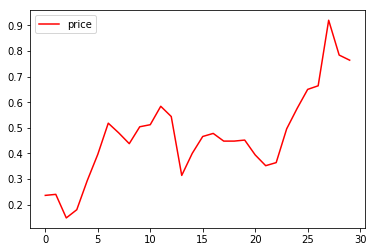

('X_train', (189, 4, 1))
('y_train', (189,))
('X_test', (47, 4, 1))
('y_test', (47,))


In [43]:
# df = pd.read_excel('stock_with_sentiment.xlsx', sheetname='600362')
df = standard_scaler('600362', normalize=True)

# X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
X_train, y_train, X_test, y_test = preprocess_data(df, window)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

In [44]:
model = build_model(shape, neurons, d)

('Compilation Time : ', 0.0395660400390625)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4, 128)            66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 128)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
__________________________

In [45]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=200,
    validation_split=0.1,
    verbose=0)

In [46]:
pred = model.predict(X_test)
print pred

[[ 0.59352905]
 [ 0.56220895]
 [ 0.56665856]
 [ 0.53984696]
 [ 0.52718151]
 [ 0.49719489]
 [ 0.44029182]
 [ 0.44766259]
 [ 0.44364542]
 [ 0.46029443]
 [ 0.4528057 ]
 [ 0.45066452]
 [ 0.45787126]
 [ 0.47121841]
 [ 0.49782842]
 [ 0.50376719]
 [ 0.51604855]
 [ 0.51438266]
 [ 0.52673733]
 [ 0.54048574]
 [ 0.53232843]
 [ 0.51617366]
 [ 0.50214767]
 [ 0.47504359]
 [ 0.44717473]
 [ 0.44568056]
 [ 0.43834239]
 [ 0.43113077]
 [ 0.42691904]
 [ 0.42220956]
 [ 0.41990286]
 [ 0.41624701]
 [ 0.41502649]
 [ 0.41860789]
 [ 0.43398833]
 [ 0.43310082]
 [ 0.41802949]
 [ 0.39154154]
 [ 0.35785198]
 [ 0.32430756]
 [ 0.32832038]
 [ 0.33422983]
 [ 0.34273756]
 [ 0.34447932]
 [ 0.34807092]
 [ 0.34695482]
 [ 0.33958209]]


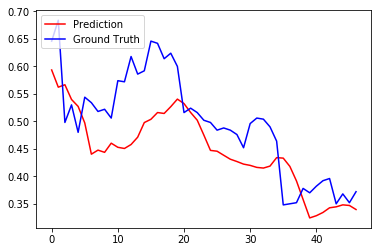

0.521739130435


In [47]:
plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

f_star=[]
f = []
v_star=[]
v=[]
for i in range(pred.size-1):
#     f_star.append((pred[i]>0.5))
#     f.append((y_test[i]>0.5))
    f_star.append((pred[i+1]-pred[i]>0))
    f.append((y_test[i+1]-y_test[i])>0)
counter = 0
for i in range(len(f)):
    if f_star[i][0] == f[i]:
        counter += 1
acc = counter * 1.0 / (len(f))
print acc

In [80]:
random_guess = []
for i in range(len(f)):
    random_guess.append(bool(random.randrange(0,2)))

random_counter = 0
for i in range(len(f)):
    if random_guess[i]==f[i]:
        random_counter+=1
random_acc = random_counter*1.0/(len(f))
print "Random guess accuracy: " + str(random_acc)

Random guess accuracy: 0.5


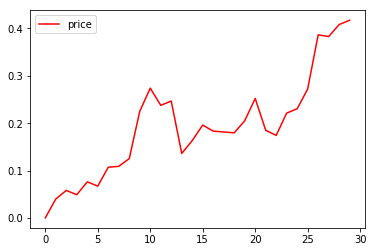

('Compilation Time : ', 0.047592878341674805)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_185 (LSTM)              (None, 1, 128)            66560     
_________________________________________________________________
dropout_185 (Dropout)        (None, 1, 128)            0         
_________________________________________________________________
lstm_186 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_186 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_185 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_186 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
________________________

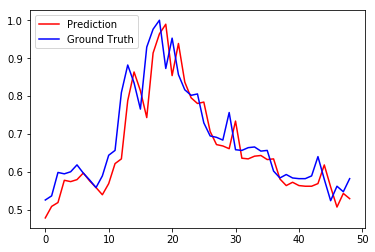

window: 1 accuracy: 0.5


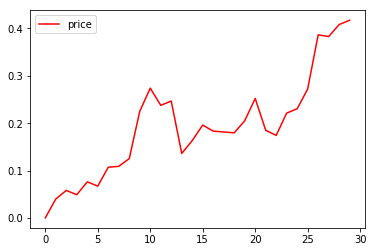

('Compilation Time : ', 0.03665518760681152)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_187 (LSTM)              (None, 2, 128)            66560     
_________________________________________________________________
dropout_187 (Dropout)        (None, 2, 128)            0         
_________________________________________________________________
lstm_188 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_188 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_187 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_188 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_________________________

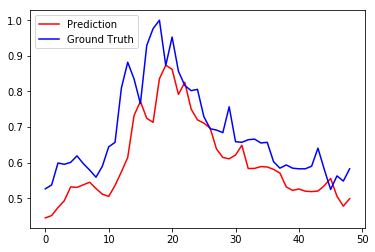

window: 2 accuracy: 0.458333333333


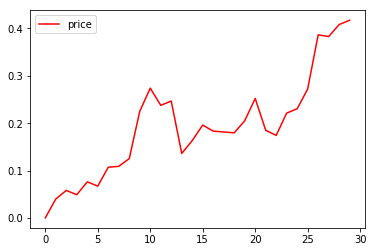

('Compilation Time : ', 0.04054999351501465)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_189 (LSTM)              (None, 3, 128)            66560     
_________________________________________________________________
dropout_189 (Dropout)        (None, 3, 128)            0         
_________________________________________________________________
lstm_190 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_190 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_189 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_190 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_________________________

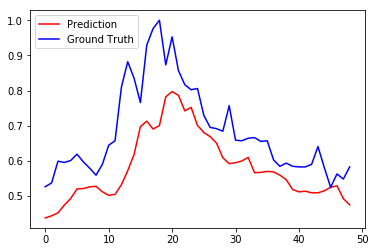

window: 3 accuracy: 0.5


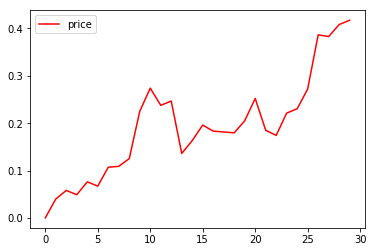

('Compilation Time : ', 0.04765582084655762)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_191 (LSTM)              (None, 4, 128)            66560     
_________________________________________________________________
dropout_191 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_192 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_192 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_191 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_192 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_________________________

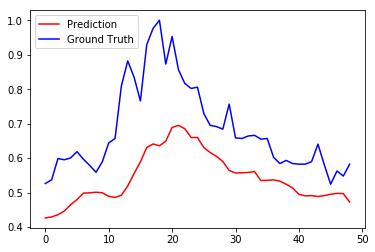

window: 4 accuracy: 0.5625


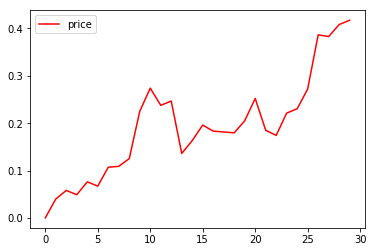

('Compilation Time : ', 0.04785799980163574)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_193 (LSTM)              (None, 5, 128)            66560     
_________________________________________________________________
dropout_193 (Dropout)        (None, 5, 128)            0         
_________________________________________________________________
lstm_194 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_194 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_193 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_194 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_________________________

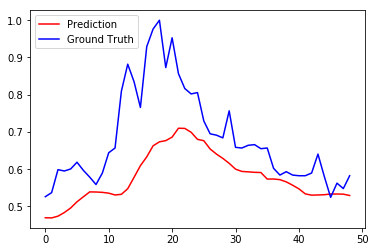

window: 5 accuracy: 0.520833333333


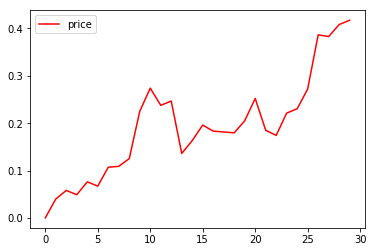

('Compilation Time : ', 0.04149293899536133)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_195 (LSTM)              (None, 6, 128)            66560     
_________________________________________________________________
dropout_195 (Dropout)        (None, 6, 128)            0         
_________________________________________________________________
lstm_196 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_196 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_195 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_196 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_________________________

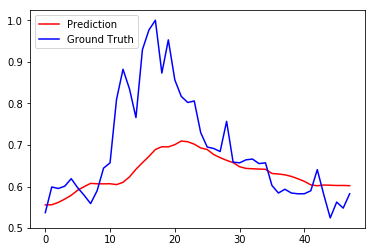

window: 6 accuracy: 0.468085106383


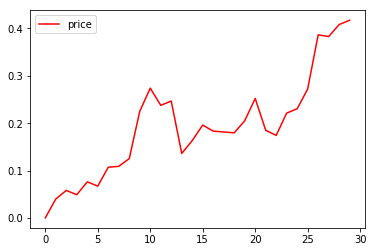

('Compilation Time : ', 0.045662879943847656)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_197 (LSTM)              (None, 7, 128)            66560     
_________________________________________________________________
dropout_197 (Dropout)        (None, 7, 128)            0         
_________________________________________________________________
lstm_198 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_198 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_197 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_198 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
________________________

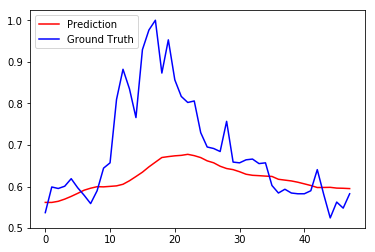

window: 7 accuracy: 0.489361702128


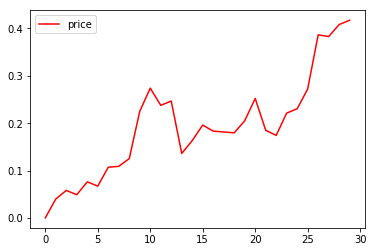

('Compilation Time : ', 0.04687094688415527)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_199 (LSTM)              (None, 8, 128)            66560     
_________________________________________________________________
dropout_199 (Dropout)        (None, 8, 128)            0         
_________________________________________________________________
lstm_200 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_200 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_199 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_200 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_________________________

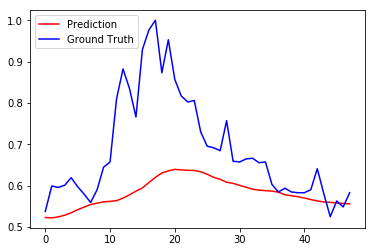

window: 8 accuracy: 0.595744680851


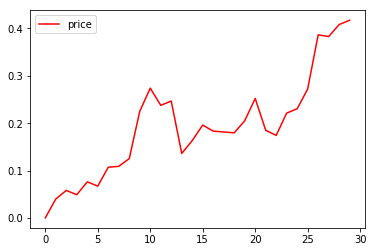

('Compilation Time : ', 0.046972036361694336)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_201 (LSTM)              (None, 9, 128)            66560     
_________________________________________________________________
dropout_201 (Dropout)        (None, 9, 128)            0         
_________________________________________________________________
lstm_202 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_202 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_201 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_202 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
________________________

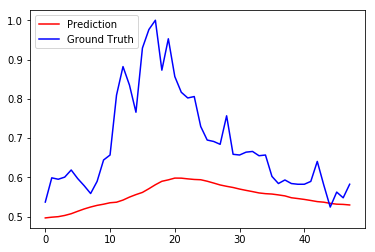

window: 9 accuracy: 0.617021276596


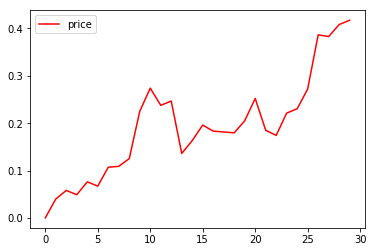

('Compilation Time : ', 0.044631004333496094)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_203 (LSTM)              (None, 10, 128)           66560     
_________________________________________________________________
dropout_203 (Dropout)        (None, 10, 128)           0         
_________________________________________________________________
lstm_204 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_204 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_203 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_204 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
________________________

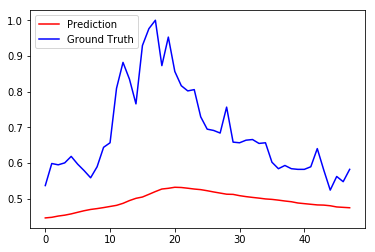

window: 10 accuracy: 0.617021276596


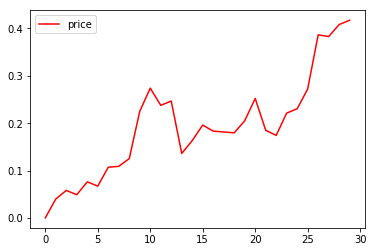

('Compilation Time : ', 0.057090044021606445)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_205 (LSTM)              (None, 11, 128)           66560     
_________________________________________________________________
dropout_205 (Dropout)        (None, 11, 128)           0         
_________________________________________________________________
lstm_206 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_206 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_205 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_206 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
________________________

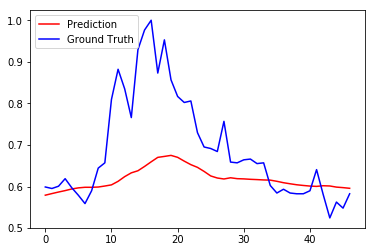

window: 11 accuracy: 0.54347826087


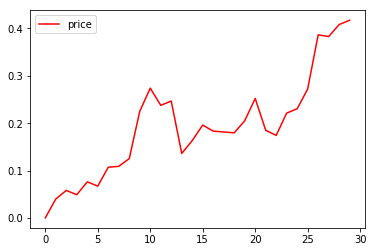

('Compilation Time : ', 0.04416990280151367)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_207 (LSTM)              (None, 12, 128)           66560     
_________________________________________________________________
dropout_207 (Dropout)        (None, 12, 128)           0         
_________________________________________________________________
lstm_208 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_208 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_207 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_208 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_________________________

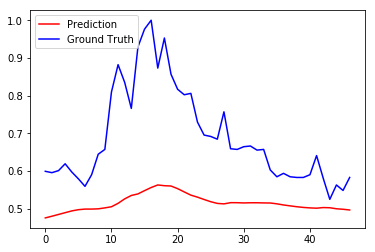

window: 12 accuracy: 0.565217391304


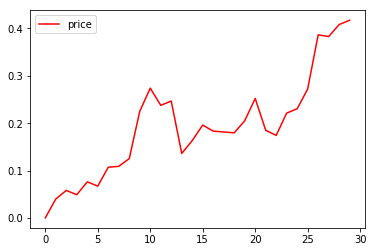

('Compilation Time : ', 0.04760885238647461)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_209 (LSTM)              (None, 13, 128)           66560     
_________________________________________________________________
dropout_209 (Dropout)        (None, 13, 128)           0         
_________________________________________________________________
lstm_210 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_210 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_209 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_210 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_________________________

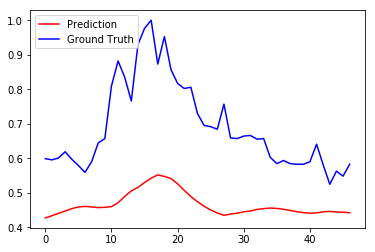

window: 13 accuracy: 0.521739130435


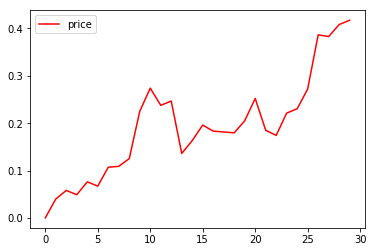

('Compilation Time : ', 0.03988981246948242)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_211 (LSTM)              (None, 14, 128)           66560     
_________________________________________________________________
dropout_211 (Dropout)        (None, 14, 128)           0         
_________________________________________________________________
lstm_212 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_212 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_211 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_212 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_________________________

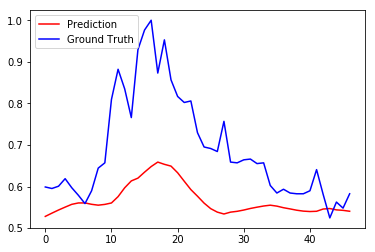

window: 14 accuracy: 0.521739130435


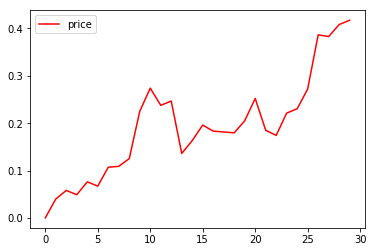

('Compilation Time : ', 0.03796792030334473)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_213 (LSTM)              (None, 15, 128)           66560     
_________________________________________________________________
dropout_213 (Dropout)        (None, 15, 128)           0         
_________________________________________________________________
lstm_214 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_214 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_213 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_214 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_________________________

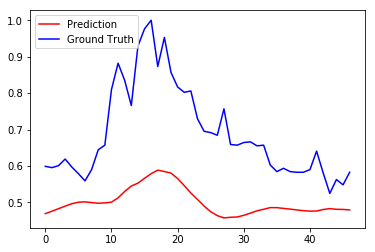

window: 15 accuracy: 0.521739130435


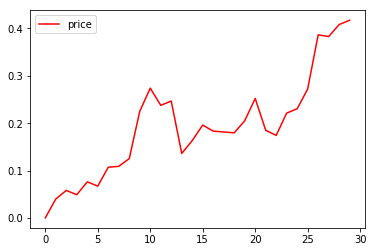

('Compilation Time : ', 0.04398488998413086)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_215 (LSTM)              (None, 16, 128)           66560     
_________________________________________________________________
dropout_215 (Dropout)        (None, 16, 128)           0         
_________________________________________________________________
lstm_216 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_216 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_215 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_216 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_________________________

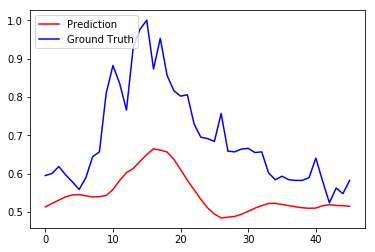

window: 16 accuracy: 0.511111111111


In [20]:
for window in range(1,17):
    # window = 4
    shape = [1, window, 1]
    neurons = [128,128,32,1]
    d=0.2
    # df = pd.read_excel('stock_with_sentiment.xlsx', sheetname='600362')
    df = standard_scaler('000573', normalize=True)

    # X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
    X_train, y_train, X_test, y_test = preprocess_data(df, window)

    model = build_model(shape, neurons, d)

    model.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=200,
        validation_split=0,
        verbose=0)

    pred = model.predict(X_test)

    plt2.plot(pred, color='red', label='Prediction')
    plt2.plot(y_test, color='blue', label='Ground Truth')
    plt2.legend(loc='upper left')
    plt2.show()

    f_star=[]
    f = []
    v_star=[]
    v=[]
    for i in range(pred.size-1):
    #     f_star.append((pred[i]>0.5))
    #     f.append((y_test[i]>0.5))
        f_star.append((pred[i+1]-pred[i]>0))
        f.append((y_test[i+1]-y_test[i])>0)
    counter = 0
    for i in range(len(f)):
        if f_star[i][0] == f[i]:
            counter += 1
    acc = counter * 1.0 / (len(f))
    print "window: "+str(window)+" accuracy: " + str(acc)
